In [1]:
import pandas as pd
import copy
from datetime import datetime
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.utils import np_utils  # 用來後續將 label 標籤轉為 one-hot-encoding

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1. Overview
 * Human Activity Recognition
 * Training 資料共有19622個
 * Testing資料共有406個
 * 我們發現資料中new_window為yes時，許多測試欄位有值
  => 我的做法是捨去過多缺失值的欄位
 * 預測目標classe共有5類分別為ABCDE
  => 我們將classe類別轉換為數字型label以便進行預測
 * 另外驗證資料有problem-id 這個欄位
  => 我們發現它只出現在這個資料中，所以也將該欄位移除

In [2]:
#%% 1.	Overview
orig_train_df = pd.read_csv('pml-training.csv')
orig_train_df.head()
orig_train_df.describe()
print(orig_train_df.count())

orig_val_df = pd.read_csv('pml-testing.csv')
orig_val_df.head()
orig_val_df.describe()
print(orig_val_df.count())
#%%
[print(c) for c in orig_train_df.columns] # origin columns
[print(c) for c in orig_val_df.columns] # origin columns

D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (11,14,19,22,25,70,73,86,87,89,90,94,97,100) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unnamed: 0                 19622
user_name                  19622
raw_timestamp_part_1       19622
raw_timestamp_part_2       19622
cvtd_timestamp             19622
new_window                 19622
num_window                 19622
roll_belt                  19622
pitch_belt                 19622
yaw_belt                   19622
total_accel_belt           19622
kurtosis_roll_belt           406
kurtosis_picth_belt          406
kurtosis_yaw_belt            406
skewness_roll_belt           406
skewness_roll_belt.1         406
skewness_yaw_belt            406
max_roll_belt                406
max_picth_belt               406
max_yaw_belt                 406
min_roll_belt                406
min_pitch_belt               406
min_yaw_belt                 406
amplitude_roll_belt          406
amplitude_pitch_belt         406
amplitude_yaw_belt           406
var_total_accel_belt         406
avg_roll_belt                406
stddev_roll_belt             406
var_roll_belt                406
          

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

# 2.	Background
 * Unnamed: 0 : index-->不重要
 * user_name : 使用者名字
 * raw_timestamp_part_1 : 時間戳記1
 * raw_timestamp_part_2 : 時間戳記2
 * cvtd_timestamp : 測試日期
 * new_window (yes/no) : 測試窗口 -->不重要
 * num_window  : 測試窗口數-->不重要
 * classe: 預測類別(Label) - training
 * problem_id: 錯誤代碼 - testing
 
### 皮帶測量值 (Belt)
 * 一般 : row、pitch、yaw、total
 * 陀螺儀 : gyros
 * 加速度 : accel
 * 強度 : magnet
 * 方向 : x,y,z
 
#### 細部測量值 (取決於 new_window)

 * 波峰 kurtosis
 * 偏移 skewness
 * 最大 max
 * 最小 min
 * 震幅 amplitude
 * 方差 var
 * 平均 avg
 * 標準差 stddev

 
 
 ### 手腕測量值 (Arm)
 * 陀螺儀 : gyros
 * 加速度 : accel
 * 強度 : magnet
 * 方向 : x,y,z
 
 ### 啞鈴測量值 (Dumbbell)
 * 一般 : row、pitch、yaw、total
 * 陀螺儀 : gyros
 * 加速度 : accel
 * 強度 : magnet
 * 方向 : x,y,z
 
  ### 前臂測量值 (forearm)
 * 一般 : row、pitch、yaw、total
 * 陀螺儀 : gyros
 * 加速度 : accel
 * 強度 : magnet
 * 方向 : x,y,z

# 3 .Data Exploration
 ## 步驟如下
 #### 1 . 將資料裡的缺失值統一以0為填充
 #### 2 . 將數量超過一半以上的缺失欄位丟棄
 #### 3 . 丟棄以下欄位
  * ##### 'Unnamed: 0'
  * ##### 'new_window'
  * ##### 'num_window'
  * ##### 'problem_id' 

#### 4 . 進行特徵擴充
  * ##### 將時間戳記日期格式進行處理 => 取得時間差
  * ##### 將目標預測類別欄位以LabelEncoder進行編碼


In [3]:
def Clean(df):
    df = df.fillna(0)
    # 挑選DROP欄位
    dropCol = []
    # key = '#DIV/0!'
    key = 0
    for col in df.columns:
        count = list(df[col]).count(key)
        if count > df[col].count() / 2:
            dropCol.append(col)
        # print("Column:{} , Containin {} 個{}".format(col,count,key))
    # print("Column Drop:{}".format(dropCol))
    # print()
    for col in dropCol:
        df = df.drop(col,axis=1)  
    
    dropCol=['Unnamed: 0','new_window','num_window','problem_id']
    for col in dropCol:
        if col in df.columns:
            df = df.drop(col,axis=1)  

    return df

def Argu(df):
    def ts(row):
        return str(row['raw_timestamp_part_1'])+ "."+ str(row['raw_timestamp_part_2'])
    df["cvtd_timestamp"] = pd.to_datetime(df["cvtd_timestamp"])
    df["raw_timestamp"] = df.apply(ts,axis=1)
    df["raw_timestamp"] = pd.to_datetime(df["raw_timestamp"], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')
    df["raw_timestamp"] = pd.to_datetime(df["raw_timestamp"])
    df = df.drop('raw_timestamp_part_1',axis=1)  
    df = df.drop('raw_timestamp_part_2',axis=1)     
    
    def sub_dateTime(row):
        sub = (row['raw_timestamp'] - row['cvtd_timestamp']).days
        return sub

    df['Interval'] = df.apply(sub_dateTime,axis=1)
    # df[''] = df['data1'].groupby(df['key1'])
    df = df.sort_values(by=['user_name','cvtd_timestamp','raw_timestamp'])     
    df = df.reset_index(drop=True)
    df = df.drop('cvtd_timestamp',axis=1)  
    df = df.drop('raw_timestamp',axis=1)  
    df = df.drop('user_name',axis=1) 

    if 'classe' in df.columns:
        # df['classe'] = df['classe'].map(cat_mapping)
        global class_le
        class_le = LabelEncoder()
        df['classe'] = class_le.fit_transform(df['classe'].values)

    # if 'classe' in df.columns:
    #     np_utils.to_categorical(df['classe'], num_classes=5)

    return df

train_df = pd.read_csv('pml-training.csv')
train_df = Clean(train_df)
train_df = Argu(train_df)

val_df = pd.read_csv('pml-testing.csv')
val_df = Clean(val_df)
val_df = Argu(val_df)

train_df.head()
# [c for c in train_df.columns] # remain columns
# [c for c in val_df.columns] # remain columns

D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (11,14,19,22,25,70,73,86,87,89,90,94,97,100) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,roll_belt,pitch_belt,yaw_belt,total_accel_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,accel_belt_x,accel_belt_y,accel_belt_z,...,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,classe,Interval
0,122.0,-44.1,179.0,18,0.18,0.1,-0.15,45,43,-160,...,-0.75,1.95,32,112,-5,564,-377.0,157.0,0,293
1,122.0,-44.2,179.0,18,0.19,0.1,-0.15,45,43,-161,...,-1.65,2.08,46,104,7,600,-340.0,120.0,0,293
2,122.0,-44.2,179.0,18,0.18,0.1,-0.13,47,44,-160,...,-2.30,1.79,71,95,22,617,-319.0,82.0,0,293
3,122.0,-44.2,179.0,18,0.16,0.1,-0.13,44,48,-163,...,-2.44,1.38,106,82,45,646,-258.0,16.0,0,293
4,122.0,-44.2,179.0,18,0.18,0.1,-0.15,36,46,-162,...,-1.89,0.87,140,71,61,639,-221.0,-18.0,0,293


# 4.	Prediction Modeling
 ## 步驟如下
 #### 1 . 將需要作預測的特徵欄位分離出來 => feaCols
 #### 2 . 將訓練資料集的資料，以test_size為0.2的比例分割為X_train,X_test,y_train,y_test
 #### 3 . 將feature進行Normalize => 這裡用的是StandardScaler
 #### 4 . 將Label進行OneHotEncode => 這裡用的是np_utils.to_categorical
 #### 5 . 進行建模(1-h DNN)
  * ##### Input_Layer : Size = 53
  * ##### Hidden_Layer : Size = 256 ，activation='relu'
  * ##### Output_Layer : Size = 5 (predict_classes) ，activation='softmax'
  * ##### 採用categorical_crossentropy作為預測分類的Loss Function
  * ##### 採用Adam作為模型優化器
  * ##### 採用accuracy衡量準確率

#### 6 . 進行模型訓練
  * ##### 驗證集比例為0.2, 10個epochs, batch_size為32,
#### 7 . 進行模型評估
  * #####  損失約為0.11 準確率為0.966
#### 8 . 描繪模型準確率
#### 9 . 描繪模型誤差率

In [4]:
feaCols = [col  for col in train_df.columns if col!="classe"]
print(feaCols)

X_train,X_test,y_train,y_test = train_test_split(
    train_df[feaCols],
    train_df["classe"],
    test_size = 0.2,
    random_state = 0
)

sc = StandardScaler()
sc.fit(X_train)
X_train_Std = sc.transform(X_train)
X_test_Std = sc.transform(X_test)

y_TrainOneHot = np_utils.to_categorical(y_train,num_classes=5)
y_TestOneHot  = np_utils.to_categorical(y_test,num_classes=5)

#%%

def buildModel(shape):
    model = Sequential()
    # Add Input layer, 隱藏層(hidden layer) 有 256個輸出變數
    model.add(Dense(units=256, input_dim=shape[1], kernel_initializer='normal', activation='relu')) 
    # Add output layer
    model.add(Dense(units=5, kernel_initializer='normal', activation='softmax'))
    # 編譯: 選擇損失函數、優化方法及成效衡量方式
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

    return model

print(X_train_Std.shape)
model = buildModel(X_train_Std.shape)
# # 進行訓練, 訓練過程會存在 train_history 變數中
train_history = model.fit(x=X_train_Std, y=y_TrainOneHot, validation_split=0.2, epochs=10, batch_size=32, verbose=2)  

# # 顯示訓練成果(分數)
scores = model.evaluate(X_test_Std, y_TestOneHot)  
print('Loss :{} , Accuracy:{} '.format(scores[0],scores[1]))

['roll_belt', 'pitch_belt', 'yaw_belt', 'total_accel_belt', 'gyros_belt_x', 'gyros_belt_y', 'gyros_belt_z', 'accel_belt_x', 'accel_belt_y', 'accel_belt_z', 'magnet_belt_x', 'magnet_belt_y', 'magnet_belt_z', 'roll_arm', 'pitch_arm', 'yaw_arm', 'total_accel_arm', 'gyros_arm_x', 'gyros_arm_y', 'gyros_arm_z', 'accel_arm_x', 'accel_arm_y', 'accel_arm_z', 'magnet_arm_x', 'magnet_arm_y', 'magnet_arm_z', 'roll_dumbbell', 'pitch_dumbbell', 'yaw_dumbbell', 'total_accel_dumbbell', 'gyros_dumbbell_x', 'gyros_dumbbell_y', 'gyros_dumbbell_z', 'accel_dumbbell_x', 'accel_dumbbell_y', 'accel_dumbbell_z', 'magnet_dumbbell_x', 'magnet_dumbbell_y', 'magnet_dumbbell_z', 'roll_forearm', 'pitch_forearm', 'yaw_forearm', 'total_accel_forearm', 'gyros_forearm_x', 'gyros_forearm_y', 'gyros_forearm_z', 'accel_forearm_x', 'accel_forearm_y', 'accel_forearm_z', 'magnet_forearm_x', 'magnet_forearm_y', 'magnet_forearm_z', 'Interval']
(15697, 53)
Train on 12557 samples, validate on 3140 samples
Epoch 1/10
 - 1s - loss:

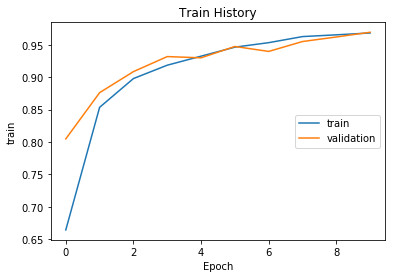

In [5]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='center right')
    plt.show()
show_train_history(train_history, 'acc','val_acc')

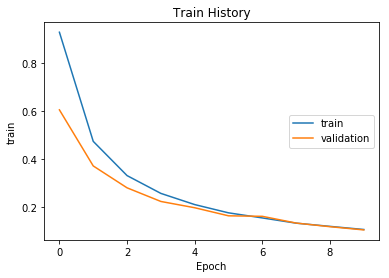

In [6]:
show_train_history(train_history, 'loss','val_loss')

# 5.	Model Application
 * 以相同方式擷取驗證資料特徵
 * 將原本LabelEncoder數值化的預測類別進行反映設
 * 並將結果附加在驗證資料集的classe欄位

In [7]:
#%% 5.	Model Application
sc = StandardScaler()
sc.fit(val_df)
X_val_Std = sc.transform(val_df)

val_df['classe'] = model.predict_classes(X_val_Std)
orig_val_df['classe'] = class_le.inverse_transform(val_df['classe'].values)
#%%
orig_val_df.head()

D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,Unnamed: 0,user_name,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp,new_window,num_window,roll_belt,pitch_belt,yaw_belt,...,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,problem_id,classe
0,1,pedro,1323095002,868349,05/12/2011 14:23,no,74,123.00,27.00,-4.75,...,-3.34,-0.59,-110,267,-149,-714,419,617,1,A
1,2,jeremy,1322673067,778725,30/11/2011 17:11,no,431,1.02,4.87,-88.90,...,-2.78,-0.18,212,297,-118,-237,791,873,2,A
2,3,jeremy,1322673075,342967,30/11/2011 17:11,no,439,0.87,1.82,-88.50,...,-0.79,0.28,154,271,-129,-51,698,783,3,B
3,4,adelmo,1322832789,560311,02/12/2011 13:33,no,194,125.00,-41.60,162.00,...,0.69,1.80,-92,406,-39,-233,783,521,4,B
4,5,eurico,1322489635,814776,28/11/2011 14:13,no,235,1.35,3.33,-88.60,...,3.10,0.80,131,-93,172,375,-787,91,5,E
